In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist
import matplotlib.gridspec as gridspec
from scipy.fftpack import fft, ifft
%matplotlib inline

In [59]:
def possible_locations(number):
    
    yeti_location_random_x = np.random.uniform(10, 30, number)
    yeti_location_random_y = np.random.uniform(-5, 15, number)
    yetixy = np.vstack((yeti_location_random_x, yeti_location_random_y)).T
    
    return (yetixy)

def travel_time(station_location, yeti_location):
    
    t_pred = cdist(station_location, yeti_location)/.310
    
    return (t_pred.T)


In [60]:
# Import  data
station_locs = pd.read_csv('StationLocation.csv')
station_headers = station_locs.columns.values

waveforms = pd.read_csv('WaveForms.csv')
waveform_headers = waveforms.columns.values
arrivaltime = np.array([64.5, 68.5, 53.5, 32.5, 21])
sigma_arrivaltime = np.array([1, 1, 1, 3.5, 2.5])
N_trials = 10**7
yeti_locs = possible_locations(N_trials)
    



<h1> Earthquake Location using a Monte Carlo Search </h1>

<h2> Overview </h2>

<p> Let's consider the following situation. Five seismic stations are set up at known locations, shown in figure 1 below, and a seismic event is recorded. Each station detects the waveform from the event, however, two stations are situated near highways and consequently those stations pick detect a substantial amount of background noise. It is assumed that this event is induced and that the wave propagates at the speed of sound (note this is not a physically valid assumption as the waves are traveling through material and only a single phase is being assumed). Our goal is to determine the location of the event. </p>

<p> In order to determine the location of the event, we need to measure the travel time of the incoming wave. Let us assume that the most likely travel time can be taken as the peak of the largest pulse. There is an uncertainty in this arrival time which must be taken into account, which is shown as error bars in the figure below. </p>

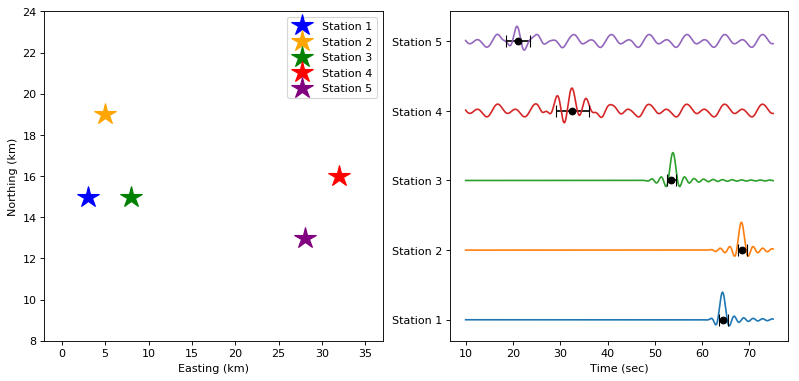

In [61]:
# Plot stations

gs = gridspec.GridSpec(2, 2)

plt.figure(figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(gs[1, 0])
ax.set_xlim([np.min(station_locs[station_headers[0]])-5,np.max(station_locs[station_headers[0]])+5])
ax.set_ylim([np.min(station_locs[station_headers[1]])-5,np.max(station_locs[station_headers[1]])+5])

colors = ['blue', 'orange', 'green', 'red', 'purple']


for idx in range(len(station_locs[station_headers[0]])):
    
    ax.plot(station_locs[station_headers[0]][idx], station_locs[station_headers[1]][idx], '*', color =  colors[idx], markersize = 20, label = 'Station {}' .format(idx+1))
    

ax.legend()
ax.set_xlabel('Easting (km)')
ax.set_ylabel('Northing (km)')

ax1 = plt.subplot(gs[1, 1])

for i in range(np.shape(waveforms)[1]-1):
    
    
    ax1.plot(waveforms[waveform_headers[0]], waveforms[waveform_headers[i+1]]+2*i)
    ax1.errorbar(arrivaltime[i], 2*i, xerr = sigma_arrivaltime[i], color = 'k', fmt='o', capsize = 5)

    
yticks = ['']


for tick in range(5):
    
    yticks.append('Station {}' .format(tick+1))
    

ax1.set_xlabel('Time (sec)')
ax1.set_yticklabels(yticks)
plt.show()


<h2> Monte Carlo Search </h2>

<p>In order to determine the location of the event a Monte Carlo search will be performed. A Monte Carlo search can conceptually be broken down into a very simple idea: guess and check. Possible locations of the event are randomly generated and are then tested by comparing the generated samples to the observed data using a likelihood function. </p>

<h3> Generating Trial Points and the Prior </h3>

<p> The number of samples to be generated depends on the range that we want to search over (defined as the prior). As the search range increases, the number of samples must also increase in order to produce a reasonable posterior distribution. To determine the prior we look at the arrival times. We essentially have two clusters of stations. In the first cluster, station 3 recieves the first signal. Therefore the event's location cannot be North or East of station 3. The stations in cluster 2 recieve the signal sooner than cluster 1, indicating the event is closter to this cluster. Station 5 has an arrival time of about 20 seconds, corresponding to a distance of 6 km, therefore the event is unlikley to be more than 6 km south of station 5. </p>

<p> In order to produce a search region that is able to resolve the misfit surface adequetly let us choose a search range that is defined as 

$$ 10km \leq y \leq 45km $$
$$ -5km \leq y \leq 20km $$

</p>

The trial locations for the event are shown in the figure below.


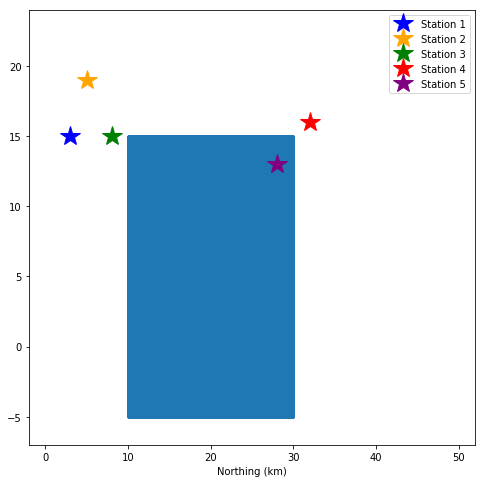

In [62]:
# Plot trial locations

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xlim([np.min(station_locs[station_headers[0]])-5,np.max(station_locs[station_headers[0]])+20])
ax.set_ylim([np.min(station_locs[station_headers[1]])-20,np.max(station_locs[station_headers[1]])+5])

colors = ['blue', 'orange', 'green', 'red', 'purple']


for idx in range(len(station_locs[station_headers[0]])):
    
    ax.plot(station_locs[station_headers[0]][idx], station_locs[station_headers[1]][idx], '*', color =  colors[idx], markersize = 20, label = 'Station {}' .format(idx+1), zorder = 100)
    

ax.legend()
ax.set_xlabel('Easting (km)')
ax.set_xlabel('Northing (km)')
ax.plot(yeti_locs[:, 0], yeti_locs[:, 1], markersize = 0.5, marker ='o', linestyle = 'none', alpha = 0.5)
plt.show()


<h2> Likelihood Function and Selection </h2>

<p>In this case a Laplacian (L1) likelihood function will be applied in order to account for the noise in stations 4 and 5 as the L1 norm is more tolerant of outliers as compared to the L2 norm. The Laplacian likelihood function is defined as 

$$\mathcal{L} \propto \exp(\sqrt{2}\sum_{station = 1}^{5}\frac{|t_{pred}-t_{obs}|}{\sigma_{station}})$$ </p>

<p> In order to accept or reject a given a location, the likelihood  for each trial location will be compared to a random number generated between 0 and 1. If the likelihood for a trial is larger than the random number then it is accepted as a valid location, otherwise the point is rejected. The accepted, possible locations for the event are shown below. </p> 



In [63]:
predicted_traveltimes = travel_time(station_locs, yeti_locs)
misfit = np.sum(np.abs(predicted_traveltimes-arrivaltime)/sigma_arrivaltime, axis=1)
likelihood = np.exp(-np.sqrt(2)*misfit)
likelihood = likelihood/np.max(likelihood)


chance = np.random.uniform(0, 1, N_trials,)
accept = np.where(likelihood>=chance)[0]
posterior = yeti_locs[accept]

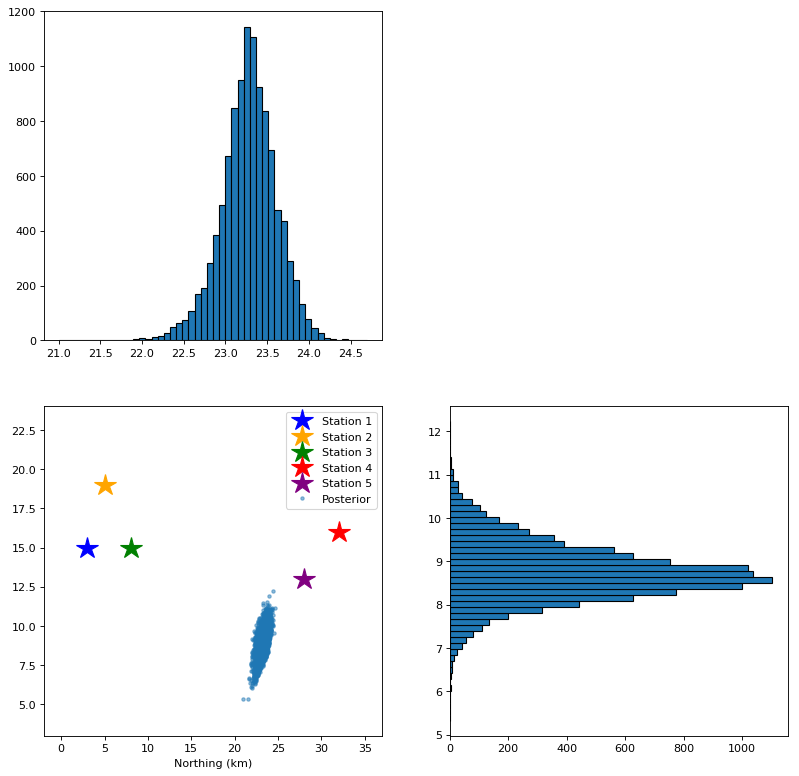

In [64]:
gs = gridspec.GridSpec(2, 2)

plt.figure(figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(gs[1, 0])
ax.set_xlim([np.min(station_locs[station_headers[0]])-5,np.max(station_locs[station_headers[0]])+5])
ax.set_ylim([np.min(station_locs[station_headers[1]])-10,np.max(station_locs[station_headers[1]])+5])

colors = ['blue', 'orange', 'green', 'red', 'purple']


for idx in range(len(station_locs[station_headers[0]])):
    
    ax.plot(station_locs[station_headers[0]][idx], station_locs[station_headers[1]][idx], '*', color =  colors[idx], markersize = 20, label = 'Station {}' .format(idx+1), zorder = 100)
    

ax.set_xlabel('Easting (km)')
ax.set_xlabel('Northing (km)')
ax.plot(posterior[:, 0], posterior[:, 1], markersize = 3, marker ='o', linestyle = 'none', label = 'Posterior', alpha = 0.5)
ax.legend()

ax1 = plt.subplot(gs[1, 1])
ax1.hist(posterior[:, 1], orientation='horizontal', bins = 50, edgecolor = 'k')
ax1 = plt.subplot(gs[0, 0])
ax1.hist(posterior[:, 0], orientation='vertical', bins = 50, edgecolor = 'k')

plt.show()
    

<h2> Analysis </h2>


There are systematic residuals, in that most of the models in the posterior tend to over-predict the arrival at stations 1 and 4. In particular, station 4 has three prominent arrivals, and the choose arrival time was chosen such that there was a large enough uncertainty to encompass all three pulse. From these predicted travel times, it is likely that the third arrival is the actual event arrival as the predicted travel-times appear to be centered on the third arrival.

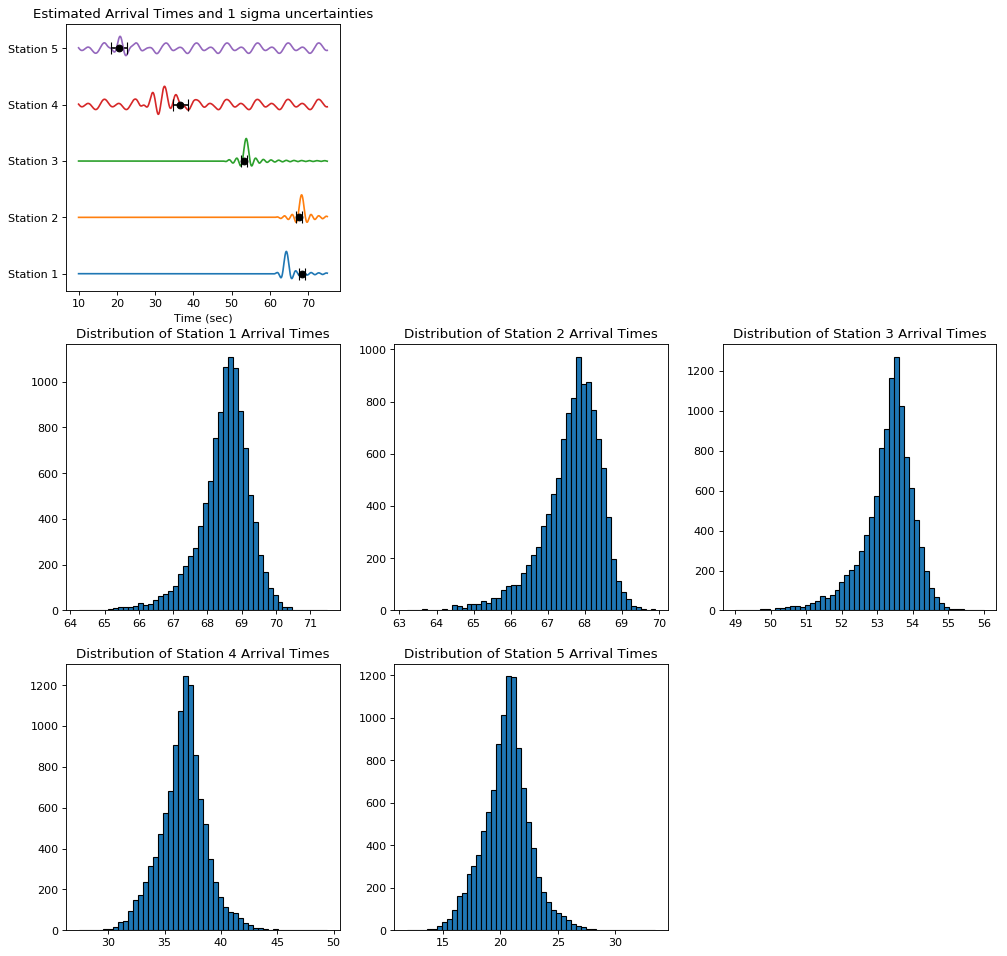

In [68]:
t_predicted = travel_time(station_locs, posterior)

gs = gridspec.GridSpec(3, 3)

plt.figure(figsize=(15, 15), dpi=80, facecolor='w', edgecolor='k')

ax0 = plt.subplot(gs[0, 0])

for i in range(np.shape(waveforms)[1]-1):
    
    
    ax0.plot(waveforms[waveform_headers[0]], waveforms[waveform_headers[i+1]]+2*i)
    ax0.errorbar(np.mean(t_predicted[:, i]), 2*i, xerr = np.std(t_predicted[:, i]), color = 'k', fmt='o', capsize = 5)

    
yticks = ['']


for tick in range(5):
    
    yticks.append('Station {}' .format(tick+1))
    

ax0.set_title('Estimated Arrival Times and 1 sigma uncertainties')
ax0.set_xlabel('Time (sec)')
ax0.set_yticklabels(yticks)

ax = plt.subplot(gs[1, 0])
ax.hist(t_predicted[:, 0], bins = 50, edgecolor = 'k')
ax.set_title('Distribution of Station 1 Arrival Times')


ax1 = plt.subplot(gs[1, 1])
ax1.hist(t_predicted[:, 1], bins = 50, edgecolor = 'k')
ax1.set_title('Distribution of Station 2 Arrival Times')

ax2 = plt.subplot(gs[1, 2])
ax2.hist(t_predicted[:, 2], bins = 50, edgecolor = 'k')
ax2.set_title('Distribution of Station 3 Arrival Times')

ax3 = plt.subplot(gs[2, 0])
ax3.hist(t_predicted[:, 3], bins = 50, edgecolor = 'k')
ax3.set_title('Distribution of Station 4 Arrival Times')

ax4 = plt.subplot(gs[2, 1])
ax4.hist(t_predicted[:, 4], bins = 50, edgecolor = 'k')
ax4.set_title('Distribution of Station 5 Arrival Times')

plt.show()

